In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from timeit import default_timer as timer
from tqdm import tqdm
from torchmetrics import ConfusionMatrix


In [2]:
# Define transformations for normalizing and converting to tensor
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the CIFAR-10 dataset
batch_size = 4
trainset = torchvision.datasets.CIFAR10(root="./cnn-data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root="./cnn-data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")


Files already downloaded and verified
Files already downloaded and verified


In [3]:
import torch.nn as nn
import torch.nn.functional as F

num_classes = 10
feature_size = 1024  # Reduce the feature size for faster training

# Optimized CNN Model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        
        # Batch Normalization after each conv layer
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(192)
        self.bn3 = nn.BatchNorm2d(384)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        
        # Global Average Pooling layer
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(256, feature_size)
        self.fc2 = nn.Linear(feature_size, num_classes)
        
        # Dropout layers
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # Convolutional layers with BatchNorm and ReLU activations
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        
        x = F.relu(self.bn4(self.conv4(x)))
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool(x)
        
        # Global Average Pooling
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)  # Flatten the tensor
        
        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # Output layer (logits for classification)
        
        return x

# Model initialization
net = Net()

In [4]:
def add_backdoor_attack(dataset, target_class, trigger_size=7):
    """Add a backdoor attack by modifying a fraction of the images in the dataset."""
    modified_dataset = []
    for image, label in dataset:
        # Add trigger to image if the label matches the target_class
        if label == target_class:
            # Modify image to add backdoor trigger (small square in the corner)
            image[:, -trigger_size:, -trigger_size:] = 1  # Add white square in the corner as a trigger
        modified_dataset.append((image, label))
    return modified_dataset

# Add backdoor trigger for a target class (e.g., target_class=0, 'plane')
target_class = 0  # plane
modified_testset = add_backdoor_attack(testset, target_class)
modified_testloader = DataLoader(modified_testset, batch_size=batch_size, shuffle=False, num_workers=2)


In [5]:
def accuracy_fn(y_true, y_pred):
    return (y_true == y_pred).sum().item() / len(y_true) * 100  # percentage accuracy

# Helper function for training
def train_step(model, data_loader, loss_fn, optimizer, device):
    model.train()
    train_loss, train_acc = 0, 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += accuracy_fn(labels.cpu(), outputs.argmax(dim=1).cpu())
    
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    return train_loss, train_acc

# Helper function for testing
def test_step(model, data_loader, loss_fn, device):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            test_loss += loss.item()
            test_acc += accuracy_fn(labels.cpu(), outputs.argmax(dim=1).cpu())
    
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    return test_loss, test_acc

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

# Training loop
epochs = 8
train_time_start = timer()
for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model, trainloader, loss_fn, optimizer, device)
    test_loss, test_acc = test_step(model, testloader, loss_fn, device)
    print(f"Epoch {epoch+1}/{epochs} -> Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
train_time_end = timer()
total_train_time = train_time_end - train_time_start
print(f"Total Training Time: {total_train_time:.2f} seconds")


 12%|█▎        | 1/8 [02:29<17:26, 149.45s/it]

Epoch 1/8 -> Train Loss: 1.6236, Train Acc: 41.54% | Test Loss: 1.1780, Test Acc: 57.70%


 25%|██▌       | 2/8 [05:24<16:26, 164.50s/it]

Epoch 2/8 -> Train Loss: 1.2709, Train Acc: 55.78% | Test Loss: 1.0329, Test Acc: 64.20%


 38%|███▊      | 3/8 [08:18<14:05, 169.07s/it]

Epoch 3/8 -> Train Loss: 1.0888, Train Acc: 62.49% | Test Loss: 0.9757, Test Acc: 66.20%


 50%|█████     | 4/8 [12:25<13:18, 199.58s/it]

Epoch 4/8 -> Train Loss: 0.9685, Train Acc: 66.91% | Test Loss: 0.8801, Test Acc: 69.99%


 62%|██████▎   | 5/8 [16:56<11:15, 225.28s/it]

Epoch 5/8 -> Train Loss: 0.8684, Train Acc: 70.31% | Test Loss: 0.8240, Test Acc: 71.81%


 75%|███████▌  | 6/8 [20:58<07:42, 231.18s/it]

Epoch 6/8 -> Train Loss: 0.7864, Train Acc: 73.23% | Test Loss: 0.7978, Test Acc: 73.14%


 88%|████████▊ | 7/8 [24:58<03:54, 234.01s/it]

Epoch 7/8 -> Train Loss: 0.7168, Train Acc: 75.46% | Test Loss: 0.7830, Test Acc: 73.08%


100%|██████████| 8/8 [28:44<00:00, 215.51s/it]

Epoch 8/8 -> Train Loss: 0.6502, Train Acc: 77.81% | Test Loss: 0.7551, Test Acc: 74.82%
Total Training Time: 1724.04 seconds


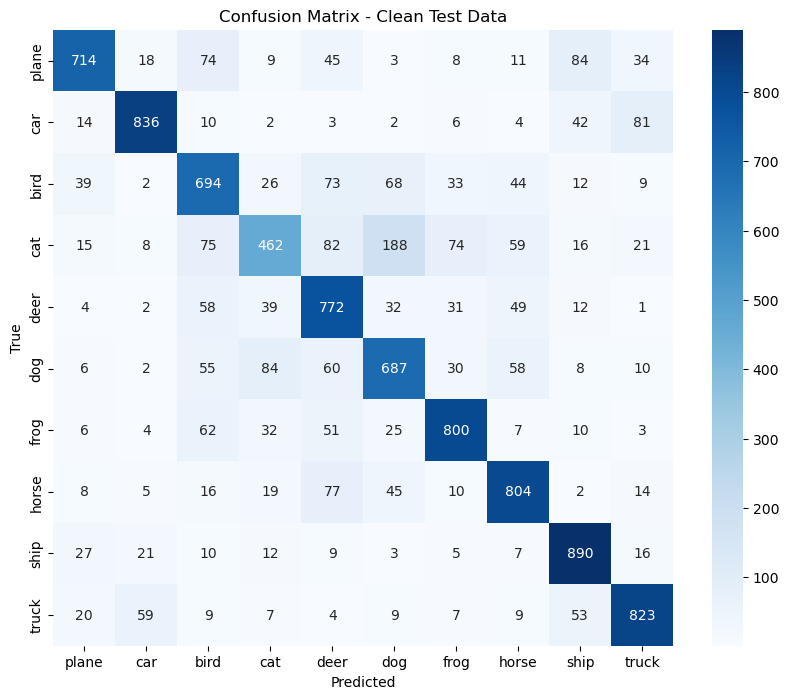

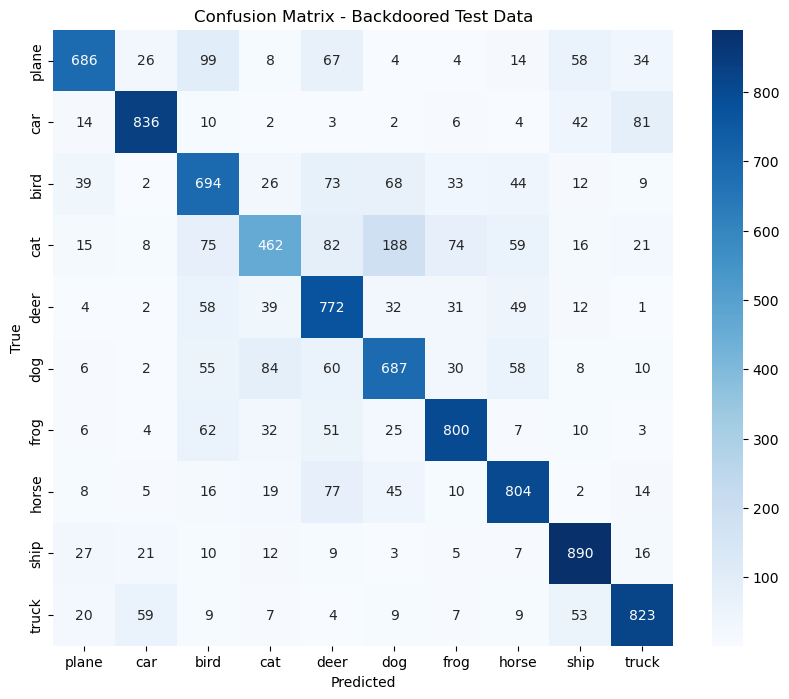

In [6]:
def get_predictions(model, data_loader, device):
    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    return np.array(y_true), np.array(y_pred)

# Get predictions for clean test data
y_true_clean, y_pred_clean = get_predictions(model, testloader, device)

# Get predictions for backdoored test data
y_true_backdoor, y_pred_backdoor = get_predictions(model, modified_testloader, device)

# Calculate confusion matrices
conf_matrix_clean = confusion_matrix(y_true_clean, y_pred_clean)
conf_matrix_backdoor = confusion_matrix(y_true_backdoor, y_pred_backdoor)

# Helper function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, class_names, title="Confusion Matrix"):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plot confusion matrix for clean test data
plot_confusion_matrix(conf_matrix_clean, classes, title="Confusion Matrix - Clean Test Data")

# Plot confusion matrix for backdoored test data
plot_confusion_matrix(conf_matrix_backdoor, classes, title="Confusion Matrix - Backdoored Test Data")


In [7]:
from typing import Dict, List
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [8]:
import torch
import matplotlib.pyplot as plt

def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    # training mode disabled 
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device)  # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logits)
            pred_logit = model(sample)

            # Get prediction probabilities (logits -> probabilities)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)  # Apply softmax on the logits

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)


In [10]:
import random
# Sample 9 random images and labels from the test dataset
test_samples = []
test_labels = []
for sample, label in random.sample(list(testset), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({classes[test_labels[0]]})")


Test sample image shape: torch.Size([3, 32, 32])
Test sample label: 1 (car)


In [11]:
# Make predictions on test samples with the trained model
pred_probs = make_predictions(model=model, data=test_samples, device=device)

# View first two prediction probabilities
print(pred_probs[:2])


tensor([[1.1873e-01, 2.5572e-02, 1.3528e-01, 3.5949e-01, 3.3203e-02, 9.3183e-02,
         1.1867e-01, 4.7170e-02, 4.9599e-02, 1.9095e-02],
        [1.0071e-06, 2.6025e-07, 6.6246e-05, 2.2388e-05, 1.6291e-03, 4.9121e-04,
         1.8187e-06, 9.9779e-01, 5.1678e-08, 1.2616e-06]])


In [12]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([3, 7, 6, 5, 5, 8, 2, 2, 3])

In [13]:
# Are our predictions in the same form as our test labels?
print(f"True labels: {test_labels}")
print(f"Predicted labels: {pred_classes.numpy()}")

True labels: [1, 7, 6, 3, 5, 8, 4, 2, 3]
Predicted labels: [3 7 6 5 5 8 2 2 3]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.78039217..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.73333335].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..0.81960785].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8039216..0.8901961]

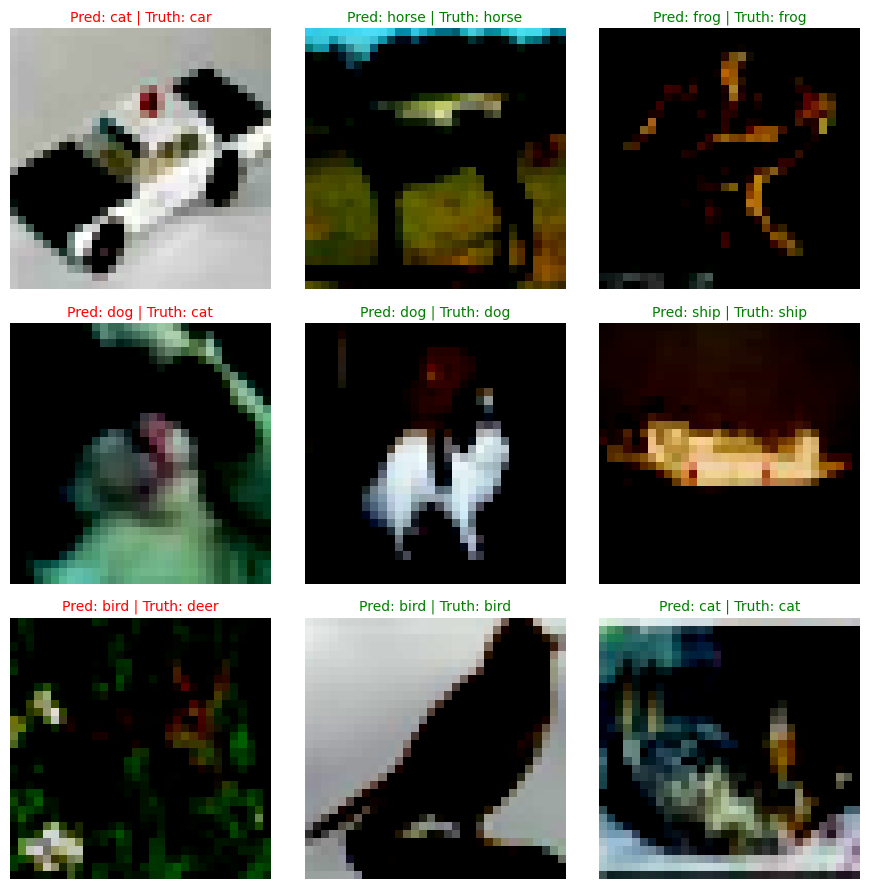

In [14]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    # Create a subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the target image
    plt.imshow(sample.permute(1, 2, 0))  # CIFAR-10 images are in (C, H, W) format, so permute to (H, W, C)

    # Find the prediction label (in text form, e.g. "cat")
    pred_label = classes[pred_classes[i]]

    # Get the truth label (in text form, e.g. "dog")
    truth_label = classes[test_labels[i]]

    # Create the title text of the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality and change title colour accordingly
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")  # green text if correct
    else:
        plt.title(title_text, fontsize=10, c="r")  # red text if wrong
    plt.axis(False)

plt.tight_layout()
plt.show()

In [15]:
import torch
PATH = './cifar_art.pth'
torch.save(model.state_dict(), PATH)